# Initializations 

In [1]:
import wntr
import pandas as pd
import numpy as np
import scipy
import copy

from scripts.valves import *
from scripts.graph import *
from scripts.simulation import *

Num nodes: 353 ;Num links: 391


/home/rewu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


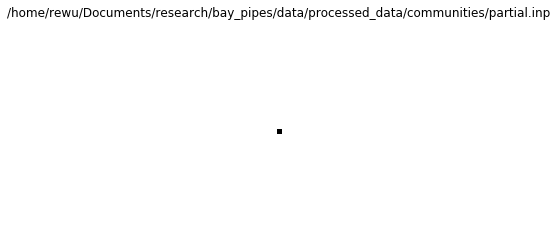

In [2]:
# Create a water network model
inp_file = '/home/rewu/Documents/research/bay_pipes/data/processed_data/communities/partial.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
wntr.graphics.plot_network(wn, title=wn.name)
n_node = len(wn.node_name_list)
n_link = len(wn.link_name_list)
print ("Num nodes:",n_node ,";Num links:", n_link)

In [3]:
inp_graph = wntr.sim.graph.NetworkRepresentor(wn)

In [4]:
def create_valves(lid2npair):
    vid = 0
    valves = []
    for lid, npairs in lid2npair.items():
        for nid in npairs:
            v = Valve(vid,nid,lid)
            vid += 1
            valves.append(v)
    return valves
        

class ValveStates(object):
    def __init__(self,valve_register,N1 = False):
        self.vreg = copy.deepcopy(valve_register)
        self.N1 = N1
        self.topo_valves = self._adjust2N_1() 
        self.valid_valves = self._init_valid_valves()
        
        self.normal_valves = self._init_valid_valves()
        self.failed_valves = []
        self.prev_state = None
        
    def _adjust2N_1(self):
        adjust_valves = []
        if self.N1:
            for nid, valves in self.vreg.nid2v.items():
                topo_valve = np.random.choice(valves, 1, replace=False)[0]
                topo_valve.keep_open = True
                topo_valve.fail = True
                adjust_valves.append(topo_valve)
        return adjust_valves
    
    def _init_valid_valves(self):
        valid_valves = []
        for vid, valve in self.vreg.vid2v.items():
            if valve not in self.topo_valves:
                valid_valves.append(valve)
        return valid_valves
    
    def _fail_valve(self,vindex):
        valve = self.normal_valves.pop(vindex)
        valve.fail = True
        return valve
    
    def fail_valves(self,nv2fail):
        self.prev_state = copy.deepcopy(self)
        failed_valves = []
        for _ in range(nv2fail):
            vidx_pool = list(range(len(self.normal_valves)))
            vidx2fail = np.random.choice(vidx_pool,1,replace=False)[0]
            failed_valve = self._fail_valve(vidx2fail)
            failed_valves.append(failed_valve)
        self.failed_valves += failed_valves
        return failed_valves
    
    def roll_back(self):
        self.vreg = self.prev_state.vreg
        self.topo_valves = self.prev_state.topo_valves
        self.normal_valves = self.prev_state.normal_valves
        self.prev_state = self.prev_state.prev_state
        
    def get_valve_dict(self):
        return self.vreg.vid2v
    
    def fail_all_valid_valves(self):
        self.prev_state = copy.deepcopy(self)
        for valid_valve in self.valid_valves:
            valid_valve.fail = True
            
    @property
    def fail_rate(self):
        return 1-len(self.normal_valves)/len(self.valid_valves)
               

In [5]:
class Segment(object):
    def __init__(self, sid):
        self.sid = sid
        self.nids = []
        self.pids = []
        
        self.risk = None
        self.direct_cost = None
        self.unintend_cost = None
       
    def __str__(self):  
        return "segment with sid %d, links to nid %s and pid %s " % (
            self.sid, str(self.nids),str(self.pids)  )
    
    def adjust_risk(self,L):
        self.risk = len(self.pids)/L
        return True
    
    def adjust_direct_cost(self):
        self.direct_cost = len(self.pids)
        
        

def create_segment_from_nullid(sid, component,num_nodes):    
    seg = Segment(sid)
    for element_id in component:
        if element_id < num_nodes:
            seg.nids.append(element_id)
        else:
            seg.pids.append(element_id-num_nodes)
    return seg

def find_segments(A, num_nodes):
    segments = []
    components = bfs(A)
    for i, component in enumerate(components):
        segment = create_segment_from_nullid(i, component,num_nodes)
        segments.append(segment)
    return segments

    
def create_adj_mtx(vstates):
    nnodes = len(vstates.vreg.nid2v)
    npipes = len(vstates.vreg.pid2v)
    vdict = vstates.get_valve_dict()
    A = assemble_adjacency_mtx(nnodes, npipes, vdict)
    return A
    
def simulate_segments(vstates):
    A = create_adj_mtx(vstates)
    nnodes = len(vstates.vreg.nid2v)
    segments = find_segments(A,nnodes)
    return segments




In [129]:
def bfs_tree(root,A):
    nids_to_explore = [root]
    component = []
    edges = []
  
    while len(nids_to_explore):
        nid = nids_to_explore.pop()
        if nid not in component:
            if (len(component)):
                edges.append((component[-1],nid))
            component.append(nid)
        row = A[nid,:]
        try:
            linked_nids = np.nonzero(row)[1]
        except:
            linked_nids = np.nonzero(row)[0]
            
        for linked_nid in linked_nids:
            if linked_nid not in component:
                nids_to_explore.append(linked_nid)
    return component,edges

    
    
def bfs(A):
    nids = set(range(A.shape[0]))
    components = []
    while len(nids):
        bfs_root = nids.pop()
        component, _ = bfs_tree(bfs_root,A)
        nids -= set(component)
        components.append(component)
    return components


In [130]:
def get_nid2seg_dict(segments):
    nid2seg = {}
    for seg in segments:
        for nid in seg.nids:
            nid2seg[nid] = seg
    return nid2seg

def get_pid2seg_dict(segments):
    pid2seg = {}
    for seg in segments:
        for pid in seg.pids:
            pid2seg[pid] = seg
    return pid2seg
        

In [152]:
class SegmentNet(object):
    def __init__(self,lid2npair,src_nids,N1=False):
        self.vstates = self._create_valvestates(lid2npair,N1)
        self.src_nids = set(src_nids)
        
        self.segments = simulate_segments(self.vstates)
        self.nid2seg = get_nid2seg_dict(self.segments)
        self.pid2seg = get_pid2seg_dict(self.segments)
        self.seg_adj_mtx = self._init_seg_adj_mtx()
        
    def _create_valvestates(self,lid2npair,N1):
        valves = create_valves(lid2npair)
        vreg = ValveRegister()
        vreg.register(valves)
        vstates = ValveStates(vreg,N1)
        return vstates
    
    def _init_seg_adj_mtx(self):
        A = np.zeros((len(self.segments),len(self.segments)))
        for v in self.vstates.normal_valves:
            seg0 = self.nid2seg[v.nid]
            seg1 = self.pid2seg[v.pid]
            A[seg0.sid,seg1.sid] = 1
            A[seg1.sid,seg0.sid] = 1 # symmetry
        return A 
    
    def _find_isolated_sidx(self,A):
        components = bfs(A)
        isolated_sidx = []
        for component in components:
            if not self.src_nids.intersection(set(component)):
                isolated_sidx += list(component)
        return isolated_sidx
        
    
    def _find_unintend_cost(self,seg_idx):
        A = copy.deepcopy(self.seg_adj_mtx)
        A[seg_idx,:] = 0
        A[:,seg_idx] = 0
        isolated_sidx = self._find_isolated_sidx(A)
        unintend_cost = -self.segments[seg_idx].direct_cost
        for sidx in isolated_sidx:
            seg = self.segments[sidx]
            unintend_cost += seg.direct_cost
        return unintend_cost
    
    def adjust_segment_risk(self):
        L = len(self.pid2seg)
        for i, seg in enumerate(self.segments):
            seg.adjust_risk(L)
        
    def adjust_segment_cost(self):
        for i, seg in enumerate(self.segments):
            seg.adjust_direct_cost()
        # direct cost for a segment must be precomputed before finding unintend cost
        for i, seg in enumerate(self.segments):
            unintend_cost = self._find_unintend_cost(i)
            print (seg.nids,seg.pids,unintend_cost)
            seg.unintend_cost = unintend_cost
    
    
        
            
            
            

In [153]:
sample_lid2nid = {0:(0,1),
                 1:(1,2),
                 2:(1,3),
                 3:(3,4),
                 4:(2,4),}
#                  5:(2,5),
#                  6:(4,5),
#                  7:(5,6),
#                  8:(5,8),
#                  9:(6,7)}

src_nids = [0]

In [154]:
segnet = SegmentNet(sample_lid2nid,src_nids)
segnet.adjust_segment_risk()
segnet.adjust_segment_cost()




[0] [] 5
[1] [] 4
[2] [] 0
[3] [] 0
[4] [] 0
[] [0] 4
[] [1] 0
[] [2] 0
[] [3] 0
[] [4] 0


In [43]:
print(segnet.seg_adj_mtx.shape)

(10, 10)


In [26]:
# valves = create_valves(inp_graph.lid2npair)
# vreg = ValveRegister()
# vreg.register(valves)

# vstates = ValveStates(vreg,False)

In [27]:
# init_segments = simulate_segments(vstates)

In [20]:
# nid2seg = get_nid2seg_dict(init_segments)
# pid2seg = get_pid2seg_dict(init_segments)